# Setup

In [5]:
# Imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import shutil
import os

import utils

from classes import Tetraloop, Chain, Fragment
from collections import Counter, OrderedDict
from pathlib import Path
from pprint import pprint
from PyPDF2 import PdfWriter

In [2]:
# matplotlib config

mpl.rcParams['figure.figsize'] = [8, 6]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
# Paths
clusters_dir = Path('../../all_clusters/')
structures_dir = Path('../../all_structures/')
data_dir = Path('data/')
fragments_dir = Path('data/fragments/')
figures_dir = Path('figures/')
training_data_dir = Path('training_data/')

# Create figures directory if none exists
if not figures_dir.exists():
    figures_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Load all data

tloops_raw = utils.load(data_dir/'tloops_raw.pickle')
tloops_filtered = utils.load(data_dir/'tloops_filtered.pickle')

chains_annotated_raw = utils.load(data_dir/'chains_annotated_raw.pickle')
chains_annotated_filtered = utils.load(data_dir/'chains_annotated_filtered.pickle')

fragments_8_raw = utils.load(fragments_dir/'fragments_8_raw.pickle')
fragments_10_raw = utils.load(fragments_dir/'fragments_10_raw.pickle')
fragments_12_raw = utils.load(fragments_dir/'fragments_12_raw.pickle')
fragments_14_raw = utils.load(fragments_dir/'fragments_14_raw.pickle')
fragments_16_raw = utils.load(fragments_dir/'fragments_16_raw.pickle')
fragments_18_raw = utils.load(fragments_dir/'fragments_18_raw.pickle')
fragments_20_raw = utils.load(fragments_dir/'fragments_20_raw.pickle')
fragments_22_raw = utils.load(fragments_dir/'fragments_22_raw.pickle')
fragments_24_raw = utils.load(fragments_dir/'fragments_24_raw.pickle')

fragments_8_filtered = utils.load(fragments_dir/'fragments_8_filtered.pickle')
fragments_10_filtered = utils.load(fragments_dir/'fragments_10_filtered.pickle')
fragments_12_filtered = utils.load(fragments_dir/'fragments_12_filtered.pickle')
fragments_14_filtered = utils.load(fragments_dir/'fragments_14_filtered.pickle')
fragments_16_filtered = utils.load(fragments_dir/'fragments_16_filtered.pickle')
fragments_18_filtered = utils.load(fragments_dir/'fragments_18_filtered.pickle')
fragments_20_filtered = utils.load(fragments_dir/'fragments_20_filtered.pickle')
fragments_22_filtered = utils.load(fragments_dir/'fragments_22_filtered.pickle')
fragments_24_filtered = utils.load(fragments_dir/'fragments_24_filtered.pickle')

fragments_filtered = [fragments_8_filtered, fragments_10_filtered, fragments_12_filtered, fragments_14_filtered, fragments_16_filtered, fragments_18_filtered, fragments_20_filtered, fragments_22_filtered, fragments_24_filtered]
fragments_raw = [fragments_8_raw, fragments_10_raw, fragments_12_raw, fragments_14_raw, fragments_16_raw, fragments_18_raw, fragments_20_raw, fragments_22_raw, fragments_24_raw]

In [5]:
# Load metadata
metadata = pd.read_csv(data_dir/'RCSB_metadata.csv', header=[1]).dropna(axis=1, how='all')

In [6]:
# Other functions

def get_res_array(sequences:list[str], res_names:list[str]=['A','U','C','G']):
    res_array= np.zeros(shape=(len(res_names), len(sequences[0])))
    for seq in sequences:
        for pos, res in enumerate(seq):
            res_array[res_names.index(res)][pos] += 1
    res_array = res_array/res_array.sum(axis=0, keepdims=True)
    return res_array


def merge_pdfs_in_dir(dir:Path, filename:str='merged_pdf'):
    merger = PdfWriter()
    for item in dir.iterdir():
        merger.append(item)
    merger.write(dir.parent/(filename + '.pdf'))
    merger.close()
    shutil.rmtree(dir)


def format_filename(text:str):
    return text.lower().replace(' ','_')

In [7]:
# Plot functions

# Plot bar graph
def plot_bar(data:dict, title:str='bar', xlabel:str='', ylabel:str='', dir:Path=figures_dir, save = True, save_as_pdf = True, **kwargs) -> None:
    ax = plt.subplots(figsize=(len(data)*0.3,3))[1]
    bar_plot = ax.bar(range(len(data)), data.values(), align='edge', width=0.5, **kwargs)
    ax.bar_label(bar_plot, rotation='vertical', padding=5)
    ax.set_xticks(range(len(data)), data.keys(), rotation='vertical', horizontalalignment='left')
    ax.set_title(title, y=1.1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
        
    # Cosmetic adjustments
    ax.margins(x=0.5/len(data), tight=True)
    ax.spines[['right', 'top']].set_visible(False)
    
    if save:
        if save_as_pdf: save_pdf(dir/format_filename(title))
        else: plt.savefig(dir/format_filename(title))

    plt.show()


# Plot stacked bar graph
def plot_stacked_bar(x, array, labels:list[str], title:str='stacked_bar', xlabel:str='', ylabel:str='', dir:Path=figures_dir, save = True, save_as_pdf = True, **kwargs) -> None:
    ax = plt.subplots(figsize=(len(x)*0.3,3))[1]
    ax.bar(x, array[0], label=labels[0])
    for i in range(1, len(array)):
        ax.bar(x, array[i], bottom=np.sum(array[:i], axis=0), label=labels[i], **kwargs)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right', bbox_to_anchor=(1.5,1.03))
    
    if save:
        if save_as_pdf: save_pdf(dir/format_filename(title))
        else: plt.savefig(dir/format_filename(title))
    
    plt.show()


def save_pdf(path:Path):
    plt.savefig(Path(path.with_suffix('.pdf')), bbox_inches='tight')
    plt.close()


def annotate_points(ax, x, y):
    for i, val in enumerate(y):
        ax.annotate(val, (x[i], y[i]))

In [8]:
def get_pdb_ids(data, unique=False, clusters=None):
    if clusters: pdb_ids = [i.pdb_id for i in data if i.clust_id in clusters]
    else: pdb_ids = [i.pdb_id for i in data]
    if unique: return set(pdb_ids)
    else: return pdb_ids


def get_seqs(data, unique=False, clusters=None):
    if clusters: seqs = [i.res_seq for i in data if i.clust_id in clusters]
    else: seqs = [i.res_seq for i in data]
    if unique: return set(seqs)
    else: return seqs


def get_counter_dict(data):
    return OrderedDict(Counter(data).most_common())

In [9]:
def stats(data, label:str ='', seqs_hist:bool=False, clust_seqs_hist:bool=False, clust_hist:bool=False, res_pos_hist:bool=False) -> None:
    
    seqs = [i.res_seq for i in data] # Sequences
    pdb_ids = [i.pdb_id for i in data] # PDB IDs
    
    print(
        f'{label}:\n'
        f'- Amount: {len(data)}\n'
        f'- Unique sequences: {len(set(seqs))}\n'
        f'- PDB IDs: {len(set(pdb_ids))}'
    )
    if isinstance(data[0], Fragment) or isinstance(data[0], Chain):
        seq_ids = [i.seq_id for i in data] # Sequence IDs (PDB ID + chain ID)
        print(f'- Chains: {len(set(seq_ids))}')
    
    # Residue position histogram
    if res_pos_hist:
        res_array = get_res_array(seqs, ['A','U','C','G','N','I'])
        plot_stacked_bar(range(len(seqs[0])), res_array, ['A','U','C','G','N','I'], f'{label} residue position frequencies', save_as_pdf=False)
    
    # Sequence histogram
    if seqs_hist:
        seqs_dict = OrderedDict(Counter(seqs).most_common())
        plot_bar(seqs_dict, f'{label} sequence frequencies')
    
    # Sequence by cluster
    if clust_seqs_hist:
        tmp_dir = figures_dir/'tmp'#Path(f'{figures_dir}/tmp')
        if tmp_dir.exists() and tmp_dir.is_dir():
            shutil.rmtree(tmp_dir)
        tmp_dir.mkdir(parents=True, exist_ok=True)
    
        clust_ids = set([i.clust_id for i in data])
        for c in clust_ids:
            clust_seqs = [t.res_seq for t in data if t.clust_id == c]
            clust_seqs_dict = OrderedDict(Counter(clust_seqs).most_common())
            plot_bar(clust_seqs_dict, f'{label} cluster {c} sequence frequencies', dir=tmp_dir)
        merge_pdfs_in_dir(tmp_dir, format_filename(f'{label} cluster sequence frequencies.pdf'))
    
    # Cluster histogram
    if clust_hist:
        clust_ids = [t.clust_id for t in data]
        clust_ids_dict = OrderedDict(sorted(Counter(clust_ids).items()))
        plot_bar(clust_ids_dict, f'{label} cluster frequencies')

    print(f'Figures saved to /{figures_dir}\n')

## PDB ID (metadata)

In [53]:
# # PDB ID query string for RCSB
# print(", ".join(set([i.pdb_id for i in tloops_raw])))

1j5e, 1e4p, 1yij, 2p89, 379d, 4u53, 2koc, 5dm6, 2ku0, 2zzm, 4qk9, 3w3s, 1hs3, 1zdh, 2uub, 1un6, 1zig, 2aht, 4gkk, 4v7x, 3d0x, 4zt9, 4v5a, 1hnw, 4v9o, 4v9k, 4wt8, 2uu9, 3lqx, 5mdz, 1dk1, 1k4a, 4v5k, 2pxb, 3g6e, 3zjv, 1nyb, 5doy, 1y39, 4v7w, 3skr, 1fyo, 1txs, 1zdi, 4wfm, 2ktz, 2tob, 4v7y, 1rlg, 4u1u, 2mqv, 3ndb, 1nwy, 2lhp, 5fkh, 5ibb, 2qex, 4w2h, 3j9m, 1ffk, 1kuq, 2euy, 2nc1, 4w2i, 2bny, 3e5f, 3ccu, 4y1j, 2n3r, 4b3t, 2v3c, 1q29, 4wqr, 5msf, 3skz, 2hua, 1i94, 2o44, 3rw6, 2n3q, 4v6a, 4v9p, 5fdu, 5fj1, 4e8p, 4c7o, 5j4d, 2lup, 1vqn, 1ldz, 4pqv, 4nxh, 5f98, 2oiu, 1r7z, 1yi2, 4b5r, 1vqm, 1rfr, 4oqu, 2i7e, 1xnq, 4u27, 3u4m, 4v8x, 4dv6, 4ji7, 4w4g, 5fk6, 3skw, 5jc9, 1hr2, 4k27, 4w92, 4k50, 4wsd, 5f8k, 1yjn, 2jyf, 4l47, 3rg5, 4wpo, 4v83, 4v9f, 3jct, 5dat, 5mrc, 3umy, 4v6c, 4ypb, 4wra, 5b2o, 1njp, 4dr3, 4lvx, 4p9r, 3iqp, 2jwv, 4v99, 2jxv, 2e5l, 4u3u, 4v6g, 2pxk, 5an9, 5dm7, 4un5, 4v8d, 1kqs, 4u55, 2uxc, 5ib8, 28sp, 5j02, 5j7l, 1q93, 3slm, 4v8c, 3adc, 4v7s, 5t62, 1n66, 5j4b, 5b2q, 2pxq, 1m90, 1s9s

In [42]:
# SKIP
# def get_metadata(pdb_id:str):
#     metadata = {"organisms": []}

#     # def get_entity_details(line:str):
#     #     data = line.split()
#     #     if len(data) > 1 and data[1] not in ["non-polymer", "water"]:
#     #         nonlocal lines
#     #         lines += [line.strip()]
    
#     def get_organism(line: str):
#         # nonlocal metadata
#         metadata["organisms"] += [line.split("'")[1]]

#     with open((structures_dir/pdb_id).with_suffix('.cif'), 'r') as file:
#         callable = lambda *args: None
#         for line in file:

#             # Decription
#             if "_struct_keywords.pdbx_keywords" in line:
#                 metadata["classification"] = line.split(" ", 1)[1].strip().strip("'")
            
#             # Organism
#             elif (  "_pdbx_entity_src_syn.organism_scientific" in line
#                     or "_em_entity_assembly_naturalsource.organism" in line
#                     or "_entity_src_gen.pdbx_gene_src_scientific_name" in line):
#                 metadata["organisms"] += [line.split(" ", 1)[1].strip().strip("'")]
            
#             elif "_entity_src_nat.details" in line: 
#                 callable = get_organism
#                 continue
            
#             elif "#" in line:
#                 callable = lambda *args: None
            
#             # case '_entity.details': callable = get_entity_details; continue
#             # # _entity.details

#             callable(line)
#     metadata["organisms"] = set(filter(None, metadata["organisms"]))
#     return metadata

# for pdb_id in [i.pdb_id for i in chains_annotated_filtered][:20]:
#     print(f"{pdb_id:5}{get_metadata(pdb_id)}")

In [12]:
# SKIP
# Retrieve structure and organism info as CSV

# def get_rcsb_info(pdb_id: str):
#     entry_url = f"https://data.rcsb.org/rest/v1/core/entry/{pdb_id}"
#     entry_response = requests.get(entry_url)
#     if entry_response.status_code == 200:
#         entry_info = {"entities": {}}
#         entry_data = entry_response.json()
#         entry_info["classification"] = entry_data['struct_keywords']['pdbx_keywords']
#         entity_ids = entry_data["rcsb_entry_container_identifiers"]["entity_ids"]
#         for entity_id in entity_ids:
#             entity_url = f"https://data.rcsb.org/rest/v1/core/polymer_entity/{pdb_id}/{entity_id}"
#             entity_response = requests.get(entity_url)
#             if entity_response.status_code == 200:
#                 entity_info = {}
#                 entity_data = entity_response.json()
#                 entity_info["type"] = entity_data["entity_poly"]["type"]
#                 if "organism" not in entry_info and "rcsb_entity_source_organism" in entity_data and "scientific_name" in entity_data["rcsb_entity_source_organism"][0]: # TODO what is this key doesn't exist?
#                     entry_info["organism"] = entity_data["rcsb_entity_source_organism"][0]["scientific_name"]
#                 entity_info["description"] = entity_data["rcsb_polymer_entity"]["pdbx_description"]
#                 entry_info["entities"][entity_id] = entity_info
#     return entry_info

# pprint(get_rcsb_info('1dk1'))

In [10]:
def get_structure(pdb_id: str):
    matching_rows = metadata[metadata['Entry ID'] == pdb_id.upper()]
    if not matching_rows.empty:
        return matching_rows.iloc[0]["Stucture Keywords"]
    else:
        return ""


def get_organisms(pdb_id: str):
    organisms = []
    start_loc = metadata.index[metadata['Entry ID'] == pdb_id.upper()]
    if not start_loc.any(): return set(["N/A"])
    start_idx = start_loc.tolist()[0]
    for index, row in metadata.iloc[start_idx:].iterrows():
        if row['Entry ID'] == pdb_id.upper() or pd.isna(row['Entry ID']):
            organisms += [str(row["Source Organism"])]
        else: break
    return set([i for i in organisms if i != "nan"])

In [31]:
# Get structure and organism data

bottaro_structures = [get_structure(i).lower() for i in get_pdb_ids(tloops_filtered)]
generated_structures = [get_structure(i).lower() for i in get_pdb_ids(fragments_8_filtered, clusters=list(range(1,45)))]

bottaro_organisms = [j.lower() for i in get_pdb_ids(tloops_filtered) for j in get_organisms(i)]
generated_organisms = [j.lower() for i in get_pdb_ids(fragments_8_filtered, clusters=list(range(1,45))) for j in get_organisms(i)]

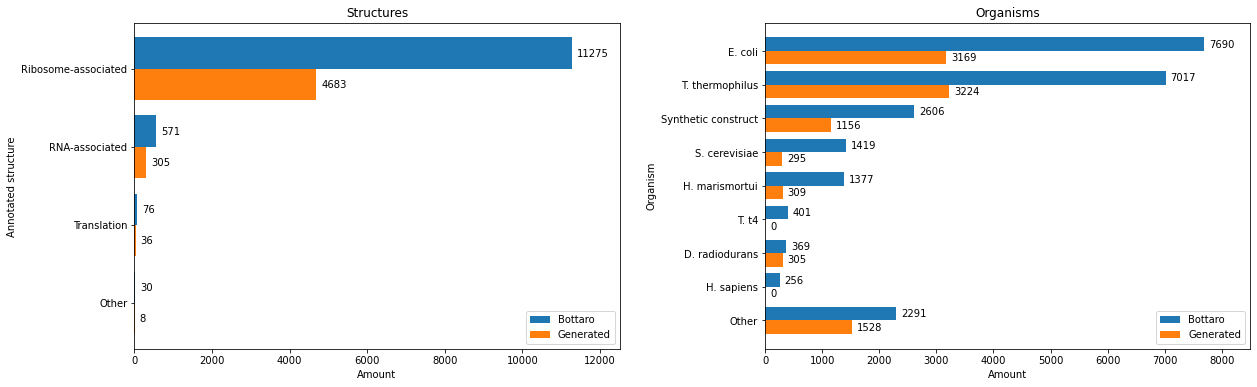

In [54]:
fig, axes = plt.subplots(1,2, figsize=(20, 6))
fig.subplots_adjust(wspace=0.3)
fig.tight_layout

bar_height = 0.4

# Structures

axes[0].set_title("Structures")
axes[0].set_ylabel("Annotated structure")
axes[0].set_xlabel("Amount")
axes[0].set_xlim([0, 12500])

other_limit = 20

# Bottaro tetraloops
bottaro_data = get_counter_dict(bottaro_structures)
bottaro_merged = {"Ribosome-associated": 0, "RNA-associated": 0, "Other": 0}
for structure, count in bottaro_data.items():
    if "ribosome" in structure: bottaro_merged["Ribosome-associated"] += count
    elif "rna" in structure:    bottaro_merged["RNA-associated"] += count
    elif count < other_limit:   bottaro_merged["Other"] += count
    else:                       bottaro_merged[structure.capitalize()] = count
bottaro_merged = dict(sorted(bottaro_merged.items(), key=lambda item: item[1]))
bottaro_merged = {'Other': bottaro_merged.pop('Other'), **bottaro_merged}

y_pos = np.arange(len(bottaro_merged))
bar = axes[0].barh(y_pos, bottaro_merged.values(), height=bar_height, align="edge")
axes[0].bar_label(bar, padding=5)
_ = axes[0].set_yticks(y_pos, labels=bottaro_merged.keys())

# Generated tetraloops
generated_data = get_counter_dict(generated_structures)
generated_merged = dict(zip(bottaro_merged.keys(), np.zeros(len(bottaro_merged))))
for structure, count in generated_data.items():
    if "ribosome" in structure: generated_merged["Ribosome-associated"] += count
    elif "rna" in structure:    generated_merged["RNA-associated"] += count
    elif count < other_limit:   generated_merged["Other"] += count
    else:                       generated_merged[structure.capitalize()] = count

bar = axes[0].barh(y_pos, generated_merged.values(), height=-bar_height, align="edge")
axes[0].bar_label(bar, padding=5)

axes[0].legend(labels=["Bottaro", "Generated"], loc="lower right")


# Organisms

axes[1].set_title("Organisms")
axes[1].set_ylabel("Organism")
axes[1].set_xlabel("Amount")
axes[1].set_xlim([0, 8500])

other_limit = 200

# Bottaro
bottaro_data = get_counter_dict(bottaro_organisms)
bottaro_merged = {"T. thermophilus": 0, "E. coli": 0, "S. cerevisiae": 0, "Other": 0}
for organism, count in bottaro_data.items():
    if "thermus thermophilus" in organism:          bottaro_merged["T. thermophilus"] += count
    elif "escherichia coli" in organism:            bottaro_merged["E. coli"] += count
    elif "saccharomyces cerevisiae" in organism:    bottaro_merged["S. cerevisiae"] += count
    elif count < other_limit:                       bottaro_merged["Other"] += count
    else:
        generic = organism.capitalize().split()[0][0] + ". "
        species = " ".join(organism.split()[1:])
        name = generic + species if organism != "synthetic construct" else organism.capitalize()
        bottaro_merged[name] = count
bottaro_merged = dict(sorted(bottaro_merged.items(), key=lambda item: item[1]))
bottaro_merged = {'Other': bottaro_merged.pop('Other'), **bottaro_merged}

y_pos = np.arange(len(bottaro_merged))
bar = axes[1].barh(y_pos, bottaro_merged.values(), height=bar_height, align="edge")
axes[1].bar_label(bar, padding=5)
_ = axes[1].set_yticks(y_pos, labels=bottaro_merged.keys())

# Generated
generated_data = get_counter_dict(generated_organisms)
generated_merged = dict(zip(bottaro_merged.keys(), np.zeros(len(bottaro_merged))))
for organism, count in generated_data.items():
    if "thermus thermophilus" in organism:          generated_merged["T. thermophilus"] += count
    elif "escherichia coli" in organism:            generated_merged["E. coli"] += count
    elif "saccharomyces cerevisiae" in organism:    generated_merged["S. cerevisiae"] += count
    elif count < other_limit:                       generated_merged["Other"] += count
    else:
        generic = organism.capitalize().split()[0][0] + ". "
        species = " ".join(organism.split()[1:])
        name = generic + species if organism != "synthetic construct" else organism.capitalize()
        generated_merged[name] = count

bar = axes[1].barh(y_pos, generated_merged.values(), height=-bar_height, align="edge")
axes[1].bar_label(bar, padding=5)

axes[1].legend(labels=["Bottaro", "Generated"], loc="lower right")

fig.savefig(figures_dir/"structures_organisms.png")

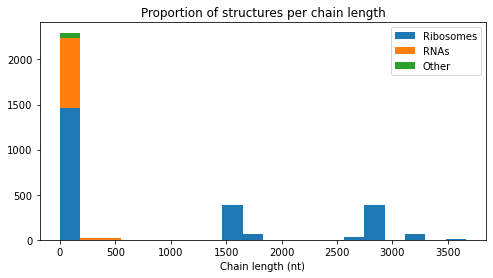

In [16]:
# Chain length vs. structure annotation

num_bins = 20


fig, ax = plt.subplots(figsize=(8,4))

ax.set_title("Proportion of structures per chain length")
ax.set_xlabel("Chain length (nt)")

chain_lengths = [len(i) for i in chains_annotated_raw]
bin_lims = np.linspace(min(chain_lengths), max(chain_lengths), num=num_bins+1)
bin_size = bin_lims[1] - bin_lims[0]

chain_bins = [[] for i in range(num_bins)]
for chain in chains_annotated_raw:
    bin_idx = int((len(chain))/bin_size)
    if bin_idx == num_bins: bin_idx -= 1
    chain_bins[bin_idx] += [chain]

size_counts = {"Ribosomes": np.zeros(num_bins), "RNAs": np.zeros(num_bins), "Other": np.zeros(num_bins)} 

for bin_idx, bin in enumerate(chain_bins):
    for chain in bin:
        structure = get_structure(chain.pdb_id).lower()
        if "ribosome" in structure: size_counts["Ribosomes"][bin_idx] += 1
        elif "rna" in structure:    size_counts["RNAs"][bin_idx] += 1
        else:                       size_counts["Other"][bin_idx] += 1

bottom = np.zeros(num_bins)
for boolean, size_count in size_counts.items():
    bars = ax.bar(bin_lims[:-1], size_count, width=bin_size, label=boolean, bottom=bottom, align='edge')
    # ax.bar_label(bars, [i if i > 30 else "" for i in size_count], padding=5)
    bottom += size_count

ax.legend(loc="upper right")

# Tetraloops
> The final tetraloop database is composed by 21,993 RNA fragments: 17,709 from X-ray, 3057 from NMR and 1227 from cryo-EM structures. The distributions of resolutions are shown in Fig. S1. [Bottaro et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5529312/)

According to Table SI1, there should be a total of 19383 tetraloops. I don't know where/what the remaining 2610 RNA fragments (from the total of 21993) are. The total number of "effective" tetraloops (members whose distance is above 0.07 eRMSD) is 16979.

In [10]:
# Cluster groups, as named in Bottaro et al. Table SI1

gnra = [1]
gnra_like = [1, 3, 6, 9, 25, 26, 36, 40]
uncg = [2]
uncg_like = [2, 5, 37, 44]
u_turn = [4]

cluster_types = {1: "GNRA", 3: "GNRA-like", 6: "GNRA-like", 9: "GNRA-like", 25: "GNRA-like", 26: "GNRA-like", 36: "GNRA-like", 40: "GNRA-like", 2: "UNCG", 5: "UNCG-like", 37: "UNCG-like", 44: "UNCG-like", 4: "U-TURN", 7: "7", 8: "8", 10: "10", 11: "4-Stack", 12: "12", 34: "34", 13: "13", 20: "20", 14: "14", 19: "19", 15: "15", 16: "16", 17: "17", 18: "18", 21: "RNYA", 22: "22", 32: "32", 43: "43", 23: "23", 24: "24", 27: "27", 28: "28", 29: "29", 30: "GGUG", 31: "31", 33: "33", 35: "CUUG", 38: "CUUG", 39: "AGNN", 41: "41", 42: "42"}

In [ ]:
# Tetraloop statistics # TODO fix residue position?

stats(tloops_raw, 'Raw tetraloops', seqs_hist=True, clust_seqs_hist=True, clust_hist=True, res_pos_hist=True)
stats(tloops_filtered, 'Filtered tetraloops', seqs_hist=True, clust_seqs_hist=True, clust_hist=True, res_pos_hist=True)
tloop_fragments = [i for i in fragments_8_raw if i.clust_id != 0]
stats(tloop_fragments, 'Generated tetraloops', seqs_hist=True, clust_seqs_hist=True, clust_hist=True, res_pos_hist=True)

|           | Number of tetraloops | Unique sequences | PDB IDs                             |
|-----------|----------------------|------------------|-------------------------------------|
| Raw       | 19383                | 292              | 864                                 |
| Filtered  | 11952                | 292              | 864                                 |
| Generated | 5032*                | 289              | 471 (572 different Chains)          |

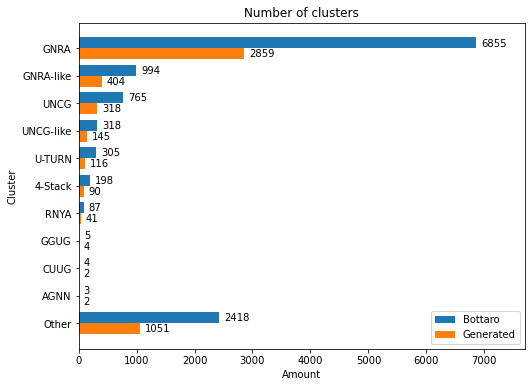

In [56]:
# Cluster analysis

height = 0.4

fig, ax = plt.subplots()
ax.set_title("Number of clusters")
ax.set_xlabel("Amount")
ax.set_ylabel("Cluster")
ax.set_xlim([0, 7700])

named_clusters = [i for i in cluster_types.values() if not i.isdigit()]

# Bottaro 
bottaro_data = get_counter_dict([i.clust_id for i in tloops_filtered])

bottaro_merged = dict(zip(named_clusters, np.zeros(len(named_clusters))))
bottaro_merged["Other"] = 0
for cluster, count in bottaro_data.items():
    cluster_name = cluster_types[cluster]
    if cluster_name.isdigit():  bottaro_merged["Other"] += count
    else:                       bottaro_merged[cluster_types[cluster]] += count
bottaro_merged = dict(reversed(list(bottaro_merged.items())))

bar = ax.barh(range(len(bottaro_merged)), bottaro_merged.values(), height=height, align="edge")
ax.set_yticks(range(len(bottaro_merged)), labels=bottaro_merged.keys())
ax.bar_label(bar, [int(i) for i in bottaro_merged.values()], padding=5)

# Generated
generated_data = get_counter_dict([i.clust_id for i in fragments_8_filtered if i.clust_id in range(1,45)])

generated_merged = dict(zip(named_clusters, np.zeros(len(named_clusters))))
generated_merged["Other"] = 0
for cluster, count in generated_data.items():
    cluster_name = cluster_types[cluster]
    if cluster_name.isdigit():  generated_merged["Other"] += count
    else:                       generated_merged[cluster_types[cluster]] += count
generated_merged = dict(reversed(list(generated_merged.items())))

bar = ax.barh(range(len(generated_merged)), generated_merged.values(), height=-height, align="edge")
ax.bar_label(bar, [int(i) for i in generated_merged.values()], padding=5)

ax.legend(labels=["Bottaro", "Generated"], loc = "lower right")


In [108]:
# Missing Tetraloop sequences (found in Bottaro but not in Generated)

tloop_raw_seqs = set([i.res_seq for i in tloops_raw])
tloop_fragment_seqs = set([i.res_seq for i in fragments_8_raw if i.clust_id != 0])
missing_seqs = tloop_raw_seqs - tloop_fragment_seqs
print(f"Sequences missing from Fragments: {missing_seqs}")
missing_tloops = [i for i in tloops_raw if i.res_seq in missing_seqs]
print(f"{len(missing_tloops)} tetraloops missing from Fragments:")
for i in missing_tloops: print(f"{i.clust_id:<3}{i.pdb_id:6}{i.res_seq:10}{i.res_nums[0]}")

Sequences missing from Fragments: {'AGGUGACU', 'AGGCGACU', 'GCGUAAGC'}
39 tetraloops missing from Fragments:
1  2gcs  AGGCGACU  112
1  2gcv  AGGCGACU  112
1  2h0s  AGGCGACU  112
1  2h0w  AGGCGACU  112
1  2h0x  AGGCGACU  112
1  2h0z  AGGCGACU  112
1  2ho6  AGGCGACU  112
1  2ho7  AGGCGACU  112
1  2nz4  AGGUGACU  107
1  2nz4  AGGUGACU  107
1  2nz4  AGGUGACU  107
1  2nz4  AGGUGACU  107
1  2z74  AGGCGACU  112
1  2z75  AGGCGACU  112
1  3b4a  AGGCGACU  112
1  3b4b  AGGCGACU  112
1  3b4c  AGGCGACU  112
1  3g8s  AGGUGACU  107
1  3g8s  AGGUGACU  107
1  3g8s  AGGUGACU  107
1  3g8s  AGGUGACU  107
1  3g8t  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g96  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3g9c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  3l3c  AGGUGACU  107
1  4meg  AGGCGACU  93
1  4meh  AGGCGACU  93
1  4r4p  GCGUAAGC  734
1  4r4v  GCGUAAGC  734
25 3g8t  AGGUGACU  

# Chains

In [104]:
stats(chains_annotated_raw, 'Raw annotated chains')
stats(chains_annotated_filtered, 'Filtered annotated chains')

Raw annotated chains:
- Amount: 3284
- Unique sequences: 1032
- PDB IDs: 864
- Chains: 3284
Figures saved to /figures

Filtered annotated chains:
- Amount: 836
- Unique sequences: 709
- PDB IDs: 533
- Chains: 836
Figures saved to /figures



|           | Number of chains | Unique sequences | PDB IDs                             |
|-----------|------------------|------------------|-------------------------------------|
| Raw       | 3284             | 1032             | 864                                 |
| Filtered  | 836              | 709              | 536                                 |
| Generated | 5032*            | 289              | 471 (572 different ReferenceChains) |

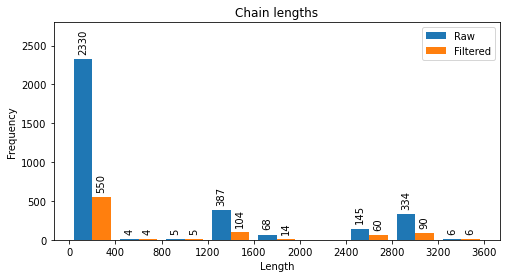

In [8]:
# Raw vs. filtered chain lengths 

fig, ax = plt.subplots(figsize=(8, 4))

ax.set_title("Chain lengths")
ax.set_xlabel("Length")
ax.set_ylabel("Frequency")
ax.set_ylim([0, 2800])

data = [[len(i) for i in chains_annotated_raw], [len(i) for i in chains_annotated_filtered]]

values, _, bars = ax.hist(data, bins = range(0, max(data[0]), 400), label=["Raw", "Filtered"], rwidth=0.8)
ax.bar_label(bars[0], labels=[int(i) if i != 0 else "" for i in values[0]], rotation='vertical', padding=5)
ax.bar_label(bars[1], labels=[int(i) if i != 0 else "" for i in values[1]], rotation='vertical', padding=5)
ax.set_xticks(range(0, max(data[0]), 400))

ax.legend()
# fig.savefig(figures_dir/"chain_lengths.png")

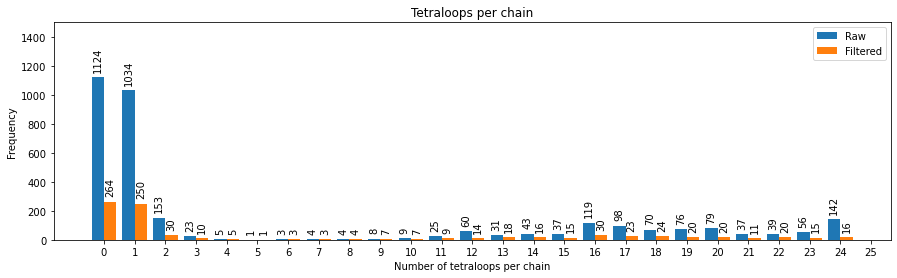

In [9]:
# Number of tetraloops per annotated chain # TODO fix x-axis
# why is the average number of tetraloops per PDB id so high (like 10 per pdb id)?
# check the chains with the highest number of tetraloops

fig, ax = plt.subplots(figsize=(15, 4))

ax.set_title("Tetraloops per chain")
ax.set_xlabel("Number of tetraloops per chain")
ax.set_ylabel("Frequency")
ax.set_ylim([0, 1500])

data = [[len(i.tloops) for i in chains_annotated_raw], [len(i.tloops) for i in chains_annotated_filtered]]

values, _, bars = ax.hist(data, bins = range(0, max(data[0])), label=["Raw", "Filtered"], rwidth=0.8, align="left")
ax.bar_label(bars[0], labels=[int(i) if i != 0 else "" for i in values[0]], rotation='vertical', padding=5)
ax.bar_label(bars[1], labels=[int(i) if i != 0 else "" for i in values[1]], rotation='vertical', padding=5)
ax.set_xticks(range(0, max(data[0])))

ax.legend()

In [ ]:
# TODO TETRALOOPS PER STRUCTURE?

# Fragments

## Unique fragments
The number of unique RNA fragments is $4^{8} = 65536$ (or $6^{8} = 1679616$, if residues I and N are included). 

Expected number of tries to obtain $x$ unique sequences:
$$\sum\limits_{i=0}^x \frac{n}{n-i}$$
where $n$ = total number of unique sequences

The expected number of tries needed to obtain *all* unique fragments is $764646$.

In [17]:
pos_unique_frags = 4**8 # TODO
print(f'Possible unique fragments: {pos_unique_frags}')

print(f'Total # of fragments: {len(fragments_8_raw)}')
unique_fragments = len(set([i.res_seq for i in fragments_8_filtered]))
print(f'Unique fragments: {unique_fragments}')

expected_tries = sum([pos_unique_frags/(pos_unique_frags-i) for i in range(unique_fragments)])
print(f'Expected # tries to obtain {unique_fragments} unique fragments: {round(expected_tries)}')

Possible unique fragments: 65536
Total # of fragments: 661843
Unique fragments: 36375
Expected # tries to obtain 36375 unique fragments: 53068


In [12]:
# Fragment set sizes (tetraloops and decoys)

raw_sizes = [len(i) for i in fragments_raw]
filtered_sizes = [len(i) for i in fragments_filtered]
raw_decoys = [len([j for j in i if j.clust_id == 0]) for i in fragments_raw]
filtered_decoys = [len([j for j in i if j.clust_id == 0]) for i in fragments_filtered]
tloops = [len([j for j in i if j.clust_id != 0]) for i in fragments_filtered]

|          |            |      8 |     10 |     12 |     14 |     16 |     18 |     20 |     22 |     24 |
|----------|------------|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|
| Raw      | Decoys     | 656811 | 655294 | 653841 | 652463 | 651147 | 649884 | 648678 | 647514 | 646391 |
|          | Tetraloops |   5032 |   5032 |   5025 |   5006 |   4991 |   4983 |   4967 |   4955 |   4941 |
|          | Total      | 661843 | 660326 | 658866 | 657469 | 656138 | 654867 | 653645 | 652469 | 651332 |
| Filtered | Decoys     |  36323 |  58871 |  63532 |  65542 |  66919 |  68007 |  68903 |  69660 |  70347 |
|          | Tetraloops |   5032 |   5032 |   5025 |   5006 |   4991 |   4983 |   4967 |   4955 |   4941 |
|          | Total      |  41355 |  63903 |  68557 |  70548 |  71910 |  72990 |  73870 |  74615 |  75288 |

In [14]:
# Number of fragments per tetraloop cluster

size_counts = {}
for cluster in range(1,45):
    size_counts[cluster] = [len([j for j in i if j.clust_id == cluster]) for i in fragments_filtered]

| Cluster\Fragment length |    8 |   10 |   12 |   14 |   16 |   18 |   20 |   22 |   24 |
|-------------------------|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|                       1 | 2859 | 2859 | 2855 | 2849 | 2847 | 2846 | 2840 | 2834 | 2821 |
|                       2 | 318  |  318 |  318 |  318 |  314 |  314 |  310 |  305 |  305 |
|                       3 | 166  |  166 |  166 |  166 |  166 |  166 |  166 |  166 |  166 |
|                       4 | 116  |  116 |  116 |  111 |  111 |  111 |  111 |  110 |  110 |
|                       5 | 142  |  142 |  142 |  142 |  142 |  142 |  142 |  142 |  142 |
|                       6 | 121  |  121 |  121 |  121 |  120 |  120 |  119 |  119 |  118 |
|                       7 | 103  |  103 |  103 |  103 |  103 |  103 |  103 |  103 |  103 |
|                       8 | 127  |  127 |  127 |  127 |  127 |  127 |  127 |  127 |  127 |
|                       9 | 81   |   81 |   81 |   81 |   80 |   80 |   80 |   80 |   80 |
|                      10 | 78   |   78 |   78 |   78 |   78 |   78 |   78 |   78 |   78 |
|                      11 | 90   |   90 |   90 |   90 |   90 |   90 |   90 |   90 |   90 |
|                      12 | 90   |   90 |   90 |   90 |   90 |   90 |   90 |   90 |   90 |
|                      13 | 65   |   65 |   65 |   65 |   65 |   65 |   65 |   65 |   65 |
|                      14 | 63   |   63 |   63 |   63 |   63 |   63 |   63 |   63 |   63 |
|                      15 | 88   |   88 |   88 |   88 |   88 |   88 |   88 |   88 |   88 |
|                      16 | 71   |   71 |   71 |   71 |   71 |   71 |   71 |   71 |   71 |
|                      17 | 66   |   66 |   66 |   66 |   66 |   66 |   66 |   66 |   66 |
|                      18 | 57   |   57 |   57 |   57 |   57 |   57 |   57 |   57 |   57 |
|                      19 | 75   |   75 |   75 |   75 |   75 |   75 |   75 |   75 |   75 |
|                      20 | 51   |   51 |   51 |   51 |   51 |   51 |   51 |   51 |   51 |
|                      21 | 41   |   41 |   38 |   30 |   24 |   19 |   16 |   16 |   16 |
|                      22 | 41   |   41 |   41 |   41 |   41 |   41 |   41 |   41 |   41 |
|                      23 | 1    |    1 |    1 |    1 |    1 |    0 |    0 |    0 |    0 |
|                      24 | 25   |   25 |   25 |   25 |   25 |   25 |   25 |   25 |   25 |
|                      25 | 14   |   14 |   14 |   14 |   14 |   14 |   14 |   14 |   14 |
|                      26 | 14   |   14 |   14 |   14 |   14 |   14 |   14 |   14 |   14 |
|                      27 | 1    |    1 |    1 |    1 |    1 |    1 |    1 |    1 |    1 |
|                      28 | 7    |    7 |    7 |    7 |    7 |    7 |    7 |    7 |    7 |
|                      29 | 7    |    7 |    7 |    7 |    7 |    6 |    5 |    5 |    5 |
|                      30 | 4    |    4 |    4 |    4 |    4 |    4 |    3 |    3 |    3 |
|                      31 | 5    |    5 |    5 |    5 |    5 |    5 |    5 |    5 |    5 |
|                      32 | 13   |   13 |   13 |   13 |   13 |   13 |   13 |   13 |   13 |
|                      33 | 5    |    5 |    5 |    5 |    5 |    5 |    5 |    5 |    5 |
|                      34 | 3    |    3 |    3 |    3 |    3 |    3 |    3 |    3 |    3 |
|                      35 | 1    |    1 |    1 |    1 |    1 |    1 |    1 |    1 |    1 |
|                      36 | 1    |    1 |    1 |    1 |    1 |    1 |    1 |    1 |    1 |
|                      37 | 1    |    1 |    1 |    1 |    1 |    1 |    1 |    1 |    1 |
|                      38 | 1    |    1 |    1 |    1 |    1 |    1 |    1 |    1 |    1 |
|                      39 | 2    |    2 |    2 |    2 |    1 |    1 |    1 |    1 |    1 |
|                      40 | 7    |    7 |    7 |    7 |    7 |    7 |    7 |    7 |    7 |
|                      41 | 1    |    1 |    1 |    1 |    1 |    1 |    1 |    1 |    1 |
|                      42 | 2    |    2 |    2 |    2 |    2 |    2 |    2 |    2 |    2 |
|                      43 | 6    |    6 |    6 |    6 |    6 |    6 |    6 |    6 |    6 |
|                      44 | 2    |    2 |    2 |    2 |    2 |    2 |    2 |    2 |    2 |

## Training datasets

In [ ]:
# train/dev/test ratios and % positive examples

training_data = {}

for dir in os.listdir(training_data_dir):
    if os.path.isfile(training_data_dir/dir): continue
    if dir[-1] == "T": continue

    data_dict = {}
    total = 0
    positives = 0

    for file in os.listdir(training_data_dir/dir):
        if file.endswith('.csv') or file.endswith('.npz'): continue

        name = file.split("_")[0]
        labels = np.load(training_data_dir/dir/file)
        data_dict[name] = len(labels)
        
        total += len(labels)
        positives += np.count_nonzero(labels == 1)
    
    data_dict["total"] = total
    data_dict["positive"] = positives
    data_dict = dict(sorted(zip(data_dict.keys(), data_dict.values())))

    data_name = "_".join(dir.split("_")[:2])
    training_data[data_name] = data_dict


# for name, data in training_data.items():
#     print(name, data)

|          | length | train | dev  | test | positive | total |
|----------|--------|-------|------|------|----------|-------|
| clusters |     18 | 58392 | 7299 | 7299 |     2846 | 72990 |
| clusters |     12 | 54845 | 6856 | 6856 |     2855 | 68557 |
| clusters |     14 | 56438 | 7055 | 7055 |     2849 | 70548 |
| clusters |     24 | 60230 | 7529 | 7529 |     2821 | 75288 |
| clusters |     16 | 57528 | 7191 | 7191 |     2847 | 71910 |
| clusters |     10 | 51122 | 6390 | 6391 |     2859 | 63903 |
| clusters |      8 | 33084 | 4135 | 4136 |     2859 | 41355 |
| clusters |     20 | 59096 | 7387 | 7387 |     2840 | 73870 |
| clusters |     22 | 59692 | 7461 | 7462 |     2834 | 74615 |
| gnra     |     24 |  3952 |  494 |  495 |     2821 |  4941 |
| gnra     |     10 |  4025 |  503 |  504 |     2859 |  5032 |
| gnra     |     16 |  3992 |  499 |  500 |     2847 |  4991 |
| gnra     |     22 |  3964 |  495 |  496 |     2834 |  4955 |
| gnra     |     14 |  4004 |  501 |  501 |     2849 |  5006 |
| gnra     |     18 |  3986 |  498 |  499 |     2846 |  4983 |
| gnra     |     20 |  3973 |  497 |  497 |     2840 |  4967 |
| gnra     |     12 |  4020 |  502 |  503 |     2855 |  5025 |
| gnra     |      8 |  4025 |  503 |  504 |     2859 |  5032 |
| gnravall |     10 | 51122 | 6390 | 6391 |     2859 | 63903 |
| gnravall |     14 | 56438 | 7055 | 7055 |     2849 | 70548 |
| gnravall |      8 | 33084 | 4135 | 4136 |     2859 | 41355 |
| gnravall |     12 | 54845 | 6856 | 6856 |     2855 | 68557 |
| tloop    |     18 | 58392 | 7299 | 7299 |     4983 | 72990 |
| tloop    |      8 | 33084 | 4135 | 4136 |     5032 | 41355 |
| tloop    |     22 | 59692 | 7461 | 7462 |     4955 | 74615 |
| tloop    |     16 | 57528 | 7191 | 7191 |     4991 | 71910 |
| tloop    |     10 | 51122 | 6390 | 6391 |     5032 | 63903 |
| tloop    |     14 | 56438 | 7055 | 7055 |     5006 | 70548 |
| tloop    |     20 | 59096 | 7387 | 7387 |     4967 | 73870 |
| tloop    |     12 | 54845 | 6856 | 6856 |     5025 | 68557 |
| tloop    |     24 | 60230 | 7529 | 7529 |     4941 | 75288 |